# Simple Neural Network with One Hidden Layer to Approximate Noisy XOR

This notebook covers a Python-based gradient descent solution for a simple neural network with one hidden layer. 
The network is supposed to separate noisy data that is approximately an XOR function on the inputs. 
It follows Peter Belhumeur's course slides (approximately) -- the only change is that there have been some changes made to make the data compatible with python 3.

## Binary Classifier

Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.228556,1.026468,0.0
1,0.024665,0.239409,0.0
2,0.045516,1.230831,1.0
3,1.206417,0.905200,0.0
4,0.890197,0.912666,0.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

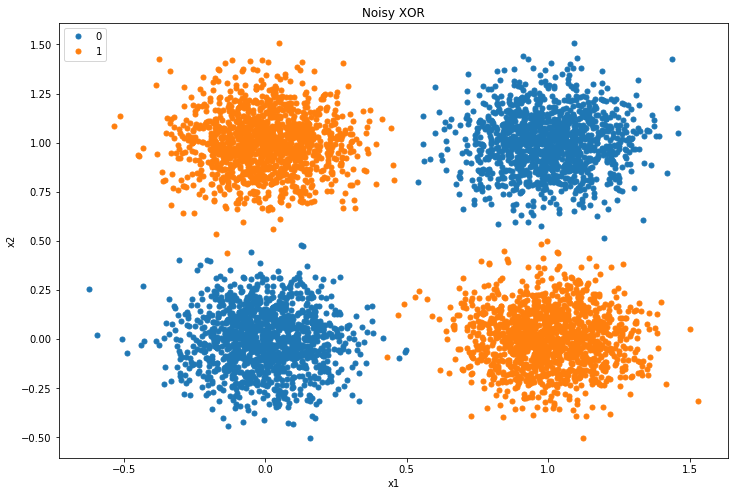

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers. Note we could be smarter and write these fucntions so they could process batches of inputs at a time, but this would partially obscure the simplicity. So instead we write these functions and their wrappers in a deliberate way.

In [6]:
def predict_layer(z):
    y_prob = 1.0 / (1.0 + np.exp(-z))
    
    return y_prob

def loss_layer_forward(z, y):
    a = (1.0 - 2.0 * y) 
    b = a * z
    L = np.log(1.0 + np.exp(b))
    
    return L

def loss_layer_backward(z, y):
    a = (1.0 - 2.0 * y) 
    b = a * z
    dL = 1.0 / (1.0 + np.exp(-b)) * a
    
    return dL

def output_layer_forward(h, w, b):
    z = np.dot(np.transpose(w), h) + b

    return z

def output_layer_backward(h, w, b, dL):
    dLdb = dL
    dLdw = np.multiply(dL, h)
    dLdh = np.multiply(dL, w)
    
    return dLdh, dLdw, dLdb

def hidden_layer_forward(x, W, c):
    a = np.dot(np.transpose(W), x) + c
    #h = np.maximum(a, 0.0) # ReLu
    h = np.maximum(a, 0.01 * a) # Leaky ReLu
    
    return h 

def hidden_layer_backward(x, W, c, dL):
    a = np.dot(np.transpose(W), x) + c
    #f = 1.0 * (a > 0.0)  # ReLu
    f = 1.0 * (a > 0.0) + 0.01 * (a < 0.0)  # Leaky ReLu
    dLdx = np.dot(W, np.multiply(f, dL))
    dLdc = np.multiply(f, dL)
    dLdW = np.dot(x, np.transpose(np.multiply(f, dL)))
    
    return dLdx, dLdW, dLdc 

def forward_prop(x, y, W, c, w, b):
    h = hidden_layer_forward(x, W, c)
    z = output_layer_forward(h, w, b)
    L = loss_layer_forward(z, y)
    
    return h, z, L

def backward_prop(x, y, h, z, W, c, w, b):
    dL = loss_layer_backward(z, y)
    dL, dLdw, dLdb = output_layer_backward(h, w, b, dL)
    dL, dLdW, dLdc = hidden_layer_backward(x, W, c, dL)
    
    return dLdW, dLdc, dLdw, dLdb 

So far so good.  Now we need to define a function to perform gradient descent on the parameters. Note the function below is naive and sloppy. It has a learning rate that is chosen without much thought. We will be lucky if this converges to a good solution!

In [7]:
def gradientDescent_batch(X, y, W, c, w, b, iters, bsize):
    cost = np.zeros(iters)
    N = X.shape[0]
      
    for t in range(1, iters):
        eta = 1.0 * np.exp(-t/100.0)
        for bdx in range(1, bsize + 1):
            k = random.randint(0, N-1)
            h, z, cost[t] = forward_prop(np.transpose(X[k,:]), y[k], W, c, w, b)
            dLdW, dLdc, dLdw, dLdb = backward_prop(np.transpose(X[k,:]), y[k], h, z, W, c, w, b)
            if bdx == 1:
                del_W = dLdW
                del_c = dLdc               
                del_w = dLdw
                del_b = dLdb
            else:
                del_W = del_W + dLdW
                del_c = del_c + dLdc
                del_w = del_w + dLdw
                del_b = del_b + dLdb
        W = W - 1.0 / bsize * eta * del_W
        c = c - 1.0 / bsize * eta * del_c
        w = w - 1.0 / bsize * eta * del_w
        b = b - 1.0 / bsize * eta * del_b
        
    return W, c, w, b, cost

Let's initialize our parameters, perform gradient descent, and see if this converges to a correct solution.

In [8]:
W = np.random.random((2, 2)) - 0.5
c = 0.1 * np.random.random((2, 1)) 
w = np.random.random((2, 1)) - 0.5
b = 0.1 * np.random.random()

iters = 1000
bsize = 16

# Note this function does not always converge to the correct solution. 
W, c, w, b, cost = gradientDescent_batch(X, y, W, c, w, b, iters, bsize)

y_predict = np.zeros(X.shape[0])
loss = np.zeros(X.shape[0])
for k in range(0, X.shape[0]):
    h, z, loss[k] = forward_prop(np.transpose(X[k,:]), y[k], W, c, w, b)
    y_predict[k] = predict_layer(z)
    
print("Loss per sample = ", np.mean(loss))
print("Done")

Loss per sample =  0.386952408848
Done


Now let's generate thousands of random points in our input feature space and see how our classifier carves up this space.

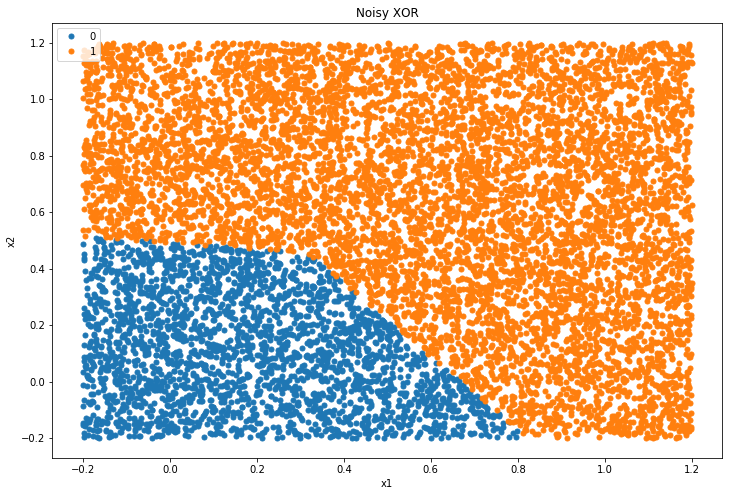

In [9]:
# This uniformly samples our input space in the range we care about
XX = 1.4 * np.matrix(np.random.random((10000, 2))) - 0.2 

# These labels don't matter, but are needed to push through our forward prop
yy = np.zeros(10000)

# Make placeholders for our predictions
yy_prob = np.zeros(10000)

for k in range(0, XX.shape[0]):
    h, z, cost = forward_prop(np.transpose(XX[k,:]), yy[k], W, c, w, b)
    yy_prob[k] = predict_layer(z)
    
plot_data(XX, yy_prob)

Yay! We did it.  Not what if we added more hidden units to the hidden layer?!

In [10]:
W = np.random.random((2, 16)) - 0.5
c = 0.1 * np.random.random((16, 1))
w = np.random.random((16, 1)) - 0.5
b = 0.1 * np.random.random()

iters = 1000
bsize = 16

# Note this function does not always converge to the correct solution. 
W, c, w, b, cost = gradientDescent_batch(X, y, W, c, w, b, iters, bsize)

y_predict = np.zeros(X.shape[0])
loss = np.zeros(X.shape[0])
for k in range(0, X.shape[0]):
    h, z, loss[k] = forward_prop(np.transpose(X[k,:]), y[k], W, c, w, b)
    y_predict[k] = predict_layer(z)
    
print("Lost per sample = {}".format(np.mean(loss)))
print("Done")

Lost per sample = 0.039445303176923005
Done


Now let's plot this network on the same data.

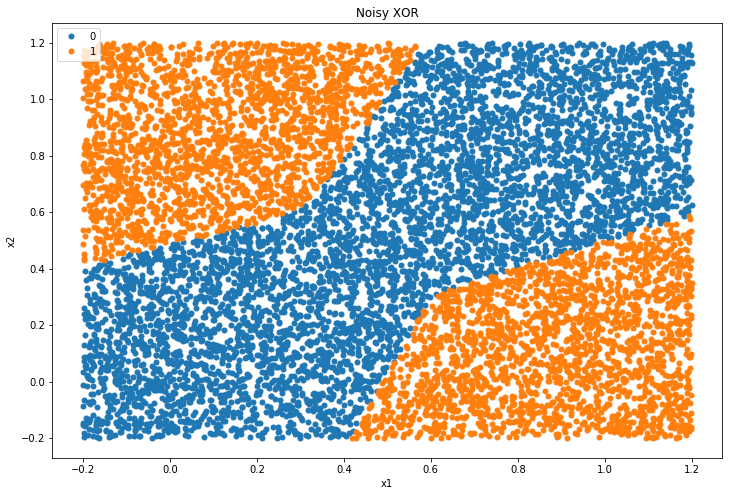

In [11]:
for k in range(0, XX.shape[0]):
    h, z, cost = forward_prop(np.transpose(XX[k,:]), yy[k], W, c, w, b)
    yy_prob[k] = predict_layer(z)
    
plot_data(XX, yy_prob)